In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import uncertainty_sampling_multiclass as usm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("Dry_Bean_Dataset.xlsx")
data = df.values

In [3]:
print(data.shape)

(13611, 17)


In [4]:
X = np.array(data[:, :-1], dtype = float)

In [5]:
Y = data[:, -1]

In [6]:
print(X.dtype)
print(Y.dtype)

float64
object


In [7]:
def normalize(x):
    dim = x.shape[1]
    x_min = np.min(x, axis = 0, keepdims = True)
    x_max = np.max(x, axis = 0, keepdims = True)
    return np.divide(x - x_min, x_max - x_min)

In [8]:
X = normalize(X)

In [9]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, test_size=0.20, random_state=0)

In [10]:
linear = svm.SVC(kernel='linear', C=1.0).fit(X_train, Y_train)
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, Y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, Y_train)

In [11]:
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [12]:
linear_accuracy = accuracy_score(Y_test, linear_pred)
linear_f1 = f1_score(Y_test, linear_pred, average='weighted')
print('Accuracy (Linear): ', "%.2f" % (linear_accuracy*100))
print('F1 (Linear): ', "%.2f" % (linear_f1*100))

Accuracy (Linear):  92.47
F1 (Linear):  92.46


In [13]:
poly_accuracy = accuracy_score(Y_test, poly_pred)
poly_f1 = f1_score(Y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  93.21
F1 (Polynomial Kernel):  93.21


In [14]:
rbf_accuracy = accuracy_score(Y_test, rbf_pred)
rbf_f1 = f1_score(Y_test, rbf_pred, average='weighted')
print('Accuracy (Rbf Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (Rbf Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (Rbf Kernel):  91.52
F1 (Rbf Kernel):  91.53


In [15]:
coeff_pas, inter_pas = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train)), 
                           init = 'zero', 
                           query = 'passive',
                           max_iter = 1e4, 
                           step_size = 2e0, 
                           batch_size = 32)

100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 4861.13it/s]


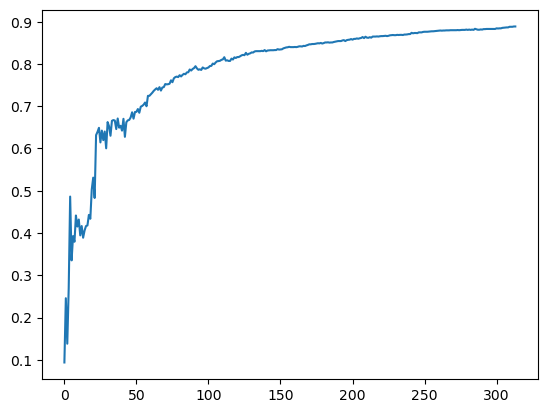

In [16]:
acc_pas = usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_pas, inter_pas, is_print = True)

In [17]:
coeff_act, inter_act = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train)), 
                           init = 'zero', 
                           query = 'active',
                           width = 2e-1,
                           max_iter = 1e4, 
                           step_size = 2e0, 
                           warm_start = 0,
                           sep_valid = True,
                           valid_ratio = 0.5,
                           update_freq = 1,
                           batch_size = 32)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.29it/s]


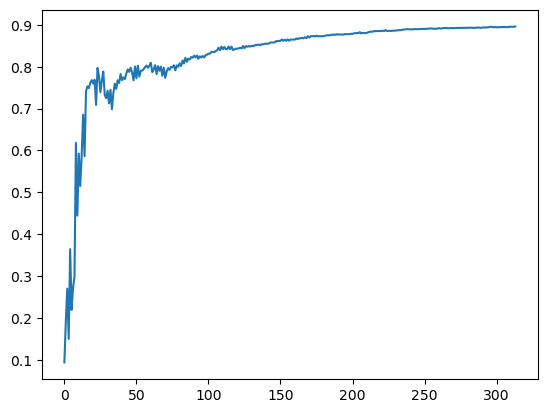

In [18]:
acc_act = usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_act, inter_act, is_print = True)

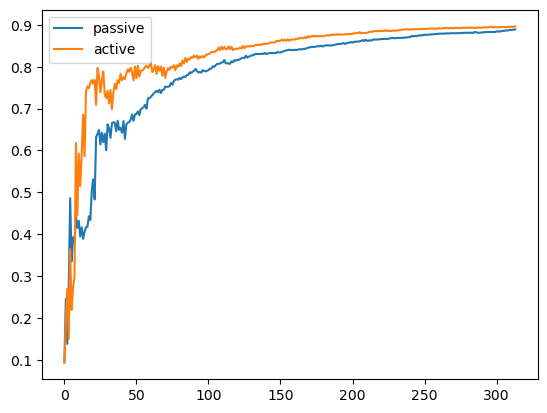

In [19]:
plt.plot(acc_pas, label = 'passive')
plt.plot(acc_act, label = 'active')
plt.legend()
plt.show()

In [20]:
trials = 30
steps = 10000
batch_size = 32
is_first = True
for t in range(trials):
    print("************************\n trial", t + 1)
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, test_size=0.20)
    init = np.random.normal(size = (X_train.shape[1] + 1, np.array(pd.get_dummies(Y_train).shape[1])))
    coeff_pas_lgr, inter_pas_lgr = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train), dtype = int),
                                              init_method = 'fixed',
                                              init = np.copy(init), 
                                              query = 'passive',
                                              max_iter = steps, 
                                              step_size = 2e0, 
                                              batch_size = batch_size,
                                              method = 'logistic_regression')
    coeff_act_lgr, inter_act_lgr = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train), dtype = int), 
                                              init_method = 'fixed',
                                              init = np.copy(init), 
                                              query = 'active',
                                              width = 2e-1,
                                              max_iter = steps, 
                                              step_size = 2e0, 
                                              warm_start = 0,
                                              sep_valid = True,
                                              valid_ratio = 0.5,
                                              update_freq = 1,
                                              batch_size = batch_size,
                                              method = 'logistic_regression')
    if is_first:
        acc_pas_lgr = np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_pas_lgr, inter_pas_lgr)) / float(trials)
        acc_act_lgr = np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_act_lgr, inter_act_lgr)) / float(trials)
        is_first = False
    else:
        acc_pas_lgr += np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_pas_lgr, inter_pas_lgr)) / float(trials)
        acc_act_lgr += np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_act_lgr, inter_act_lgr)) / float(trials)

************************
 trial 1


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.36it/s]


************************
 trial 2


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.14it/s]


************************
 trial 3


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.89it/s]


************************
 trial 4


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 14.99it/s]


************************
 trial 5


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.04it/s]


************************
 trial 6


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.71it/s]


************************
 trial 7


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.23it/s]


************************
 trial 8


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.21it/s]


************************
 trial 9


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.32it/s]


************************
 trial 10


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.29it/s]


************************
 trial 11


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.19it/s]


************************
 trial 12


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.84it/s]


************************
 trial 13


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.05it/s]


************************
 trial 14


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.36it/s]


************************
 trial 15


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 14.97it/s]


************************
 trial 16


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.10it/s]


************************
 trial 17


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.03it/s]


************************
 trial 18


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.65it/s]


************************
 trial 19


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.97it/s]


************************
 trial 20


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.48it/s]


************************
 trial 21


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.13it/s]


************************
 trial 22


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.28it/s]


************************
 trial 23


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.45it/s]


************************
 trial 24


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.49it/s]


************************
 trial 25


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.31it/s]


************************
 trial 26


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.55it/s]


************************
 trial 27


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.51it/s]


************************
 trial 28


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.74it/s]


************************
 trial 29


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:23<00:00, 13.61it/s]


************************
 trial 30


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.71it/s]


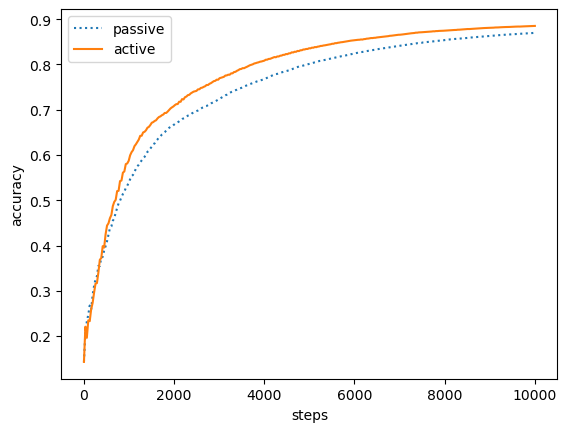

In [21]:
grid = np.arange(0, steps, batch_size)
grid = np.concatenate((grid, np.atleast_1d(steps)))
plt.plot(grid, acc_pas_lgr, label = 'passive', linestyle = 'dotted')
plt.plot(grid, acc_act_lgr, label = 'active', linestyle = 'solid')
plt.legend()
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.show()

In [22]:
coeff_pas_svm, inter_pas_svm = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train), dtype = int), 
                                                       init = 'zero', 
                                                       query = 'passive',
                                                       max_iter = 1e4, 
                                                       step_size = 5e-1, 
                                                       batch_size = 32,
                                                       method = 'svm')

100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 4318.99it/s]


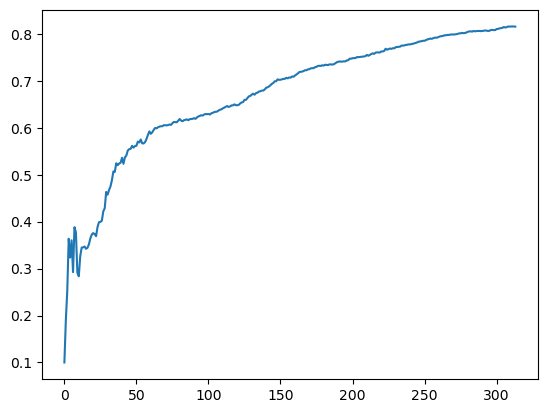

In [23]:
acc_pas_svm = usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_pas_svm, inter_pas_svm, is_print = True, method = 'svm')

In [24]:
coeff_act_svm, inter_act_svm = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train), dtype = int), 
                                                       init = 'zero', 
                                                       query = 'active',
                                                       width = 2e-1,
                                                       max_iter = 1e4, 
                                                       step_size = 5e-1, 
                                                       warm_start = 0,
                                                       sep_valid = True,
                                                       valid_ratio = 0.5,
                                                       update_freq = 1,
                                                       batch_size = 32,
                                                       method = 'svm')

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.39it/s]


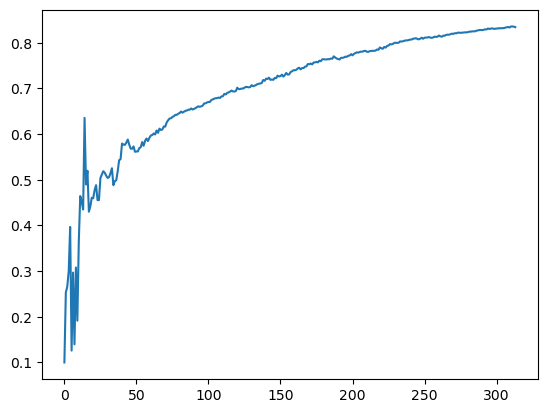

In [25]:
acc_act_svm = usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_act_svm, inter_act_svm, is_print = True, method = 'svm')

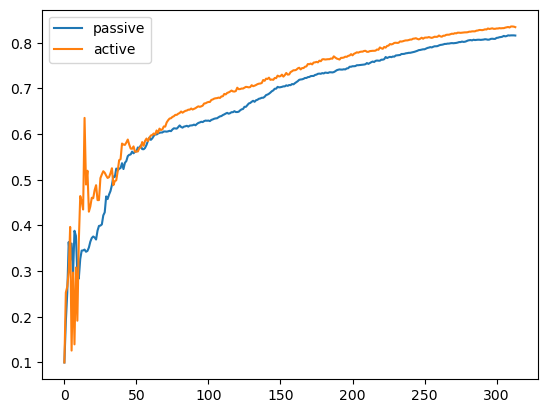

In [26]:
plt.plot(acc_pas_svm, label = 'passive')
plt.plot(acc_act_svm, label = 'active')
plt.legend()
plt.show()

In [27]:
trials = 30
steps = 10000
batch_size = 32
is_first = True
for t in range(trials):
    print("************************\n trial", t + 1)
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, test_size=0.20)
    init = np.random.normal(size = (X_train.shape[1] + 1, np.array(pd.get_dummies(Y_train).shape[1])))
    coeff_pas_svm, inter_pas_svm = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train), dtype = int),
                                                          init_method = 'fixed',
                                                          init = np.copy(init), 
                                                          query = 'passive',
                                                          max_iter = steps, 
                                                          step_size = 5e-1, 
                                                          batch_size = batch_size,
                                                          method = 'svm')
    coeff_act_svm, inter_act_svm = usm.uncertain_sampling(X_train, np.array(pd.get_dummies(Y_train), dtype = int), 
                                                          init_method = 'fixed',
                                                          init = np.copy(init), 
                                                          query = 'active',
                                                          width = 2e-1,
                                                          max_iter = steps, 
                                                          step_size = 5e-1, 
                                                          warm_start = 0,
                                                          sep_valid = True,
                                                          valid_ratio = 0.5,
                                                          update_freq = 1,
                                                          batch_size = batch_size,
                                                          method = 'svm')
    if is_first:
        acc_pas_svm = np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_pas, inter_pas)) / float(trials)
        acc_act_svm = np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_act, inter_act)) / float(trials)
        is_first = False
    else:
        acc_pas_svm += np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_pas, inter_pas)) / float(trials)
        acc_act_svm += np.asarray(usm.plot_accuracy(X_test, np.array(pd.get_dummies(Y_test)), coeff_act, inter_act)) / float(trials)

************************
 trial 1


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.66it/s]


************************
 trial 2


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.11it/s]


************************
 trial 3


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.48it/s]


************************
 trial 4


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.08it/s]


************************
 trial 5


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.20it/s]


************************
 trial 6


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.15it/s]


************************
 trial 7


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.18it/s]


************************
 trial 8


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.18it/s]


************************
 trial 9


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.21it/s]


************************
 trial 10


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.23it/s]


************************
 trial 11


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.29it/s]


************************
 trial 12


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.25it/s]


************************
 trial 13


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.52it/s]


************************
 trial 14


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.12it/s]


************************
 trial 15


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.52it/s]


************************
 trial 16


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.13it/s]


************************
 trial 17


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.53it/s]


************************
 trial 18


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.94it/s]


************************
 trial 19


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.49it/s]


************************
 trial 20


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.01it/s]


************************
 trial 21


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.15it/s]


************************
 trial 22


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.57it/s]


************************
 trial 23


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.59it/s]


************************
 trial 24


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.54it/s]


************************
 trial 25


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.03it/s]


************************
 trial 26


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.47it/s]


************************
 trial 27


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.59it/s]


************************
 trial 28


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.51it/s]


************************
 trial 29


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.43it/s]


************************
 trial 30


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.88it/s]


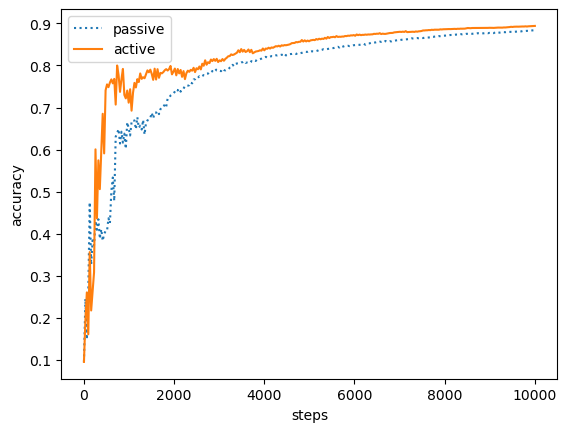

In [28]:
grid = np.arange(0, steps, batch_size)
grid = np.concatenate((grid, np.atleast_1d(steps)))
plt.plot(grid, acc_pas_svm, label = 'passive', linestyle = 'dotted')
plt.plot(grid, acc_act_svm, label = 'active', linestyle = 'solid')
plt.legend()
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


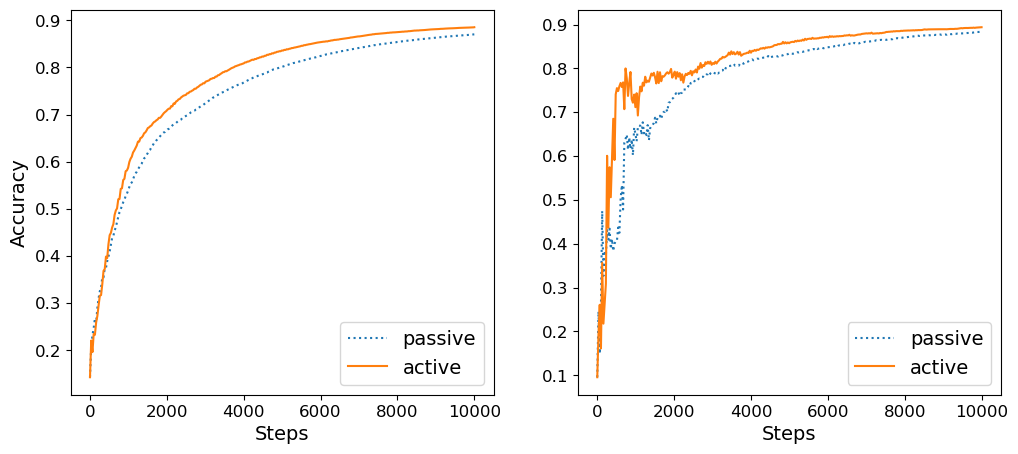

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

ax1.plot(grid, acc_pas_lgr, label = 'passive', linestyle = 'dotted')
ax1.plot(grid, acc_act_lgr, label = 'active', linestyle = 'solid')
ax2.plot(grid, acc_pas_svm, label = 'passive', linestyle = 'dotted')
ax2.plot(grid, acc_act_svm, label = 'active', linestyle = 'solid')


ax1.legend(fontsize=14)
ax1.set_xlabel('Steps', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)
ax2.legend(fontsize=14)
ax2.set_xlabel('Steps', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)

plt.savefig("Exp2_drybean.jpg", bbox_inches='tight')
plt.savefig("Exp2_drybean.eps", bbox_inches='tight')
plt.show()